In [1]:
import sys
sys.path.insert(0, '/home/ldoyle/packages')
import h5py
import numpy as np
from tqdm import tqdm
import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
import pysindy as ps
from lr_ed import localreg
from datetime import datetime
from scipy.fft import fft, fftfreq,rfft2

import scipy.signal as signal
from obspy.signal import filter as obsfilt
import glob


## Plots and Models for General Exam

### *f-k* Plot

In [2]:
path = "/data/data2/south-data-ejm/hdd/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T16_09_15-0700/"
file = "South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T231114Z.h5"
# file2 = "South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T231214Z.h5"

f = h5py.File(path+file, 'r')
data = f['Acquisition']['Raw[0]']['RawData'][:, :].astype('int64')
timestamp = f['Acquisition']['Raw[0]']['RawDataTime'][:] / 1000000
f.close()

In [3]:
# f['Acquisition'].attrs['GaugeLength']

In [4]:
time_subsample = 1
full_dat = data[7500:12500,::time_subsample]

for i in np.arange(12,31):
    file = "South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T23"+str(i)+"14Z.h5"
    f = h5py.File(path+file, 'r')
    data = f['Acquisition']['Raw[0]']['RawData'][:, :].astype('int64')
#     timestamp = f['Acquisition']['Raw[0]']['RawDataTime'][:] / 1000000
    f.close()
    
    full_dat = np.hstack((full_dat,data[7500:12500,::time_subsample]))

In [5]:
# np.arange(11,31).shape

n = 1.4682
L = 51.04762
full_dat = ((2*np.pi)/2**16)*((1550.12 * 1e-9)/(0.78 * 4 * np.pi * n * L))*full_dat 

In [6]:
# for i in np.arange(9):
#     file = "South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T232"+str(i)+"14Z.h5"
#     f = h5py.File(path+file, 'r')
#     data = f['Acquisition']['Raw[0]']['RawData'][:, :].astype('int64')
#     timestamp = f['Acquisition']['Raw[0]']['RawDataTime'][:] / 1000000
#     f.close()
    
#     full_dat = np.hstack((full_dat,data[7500:12500,::time_subsample]))

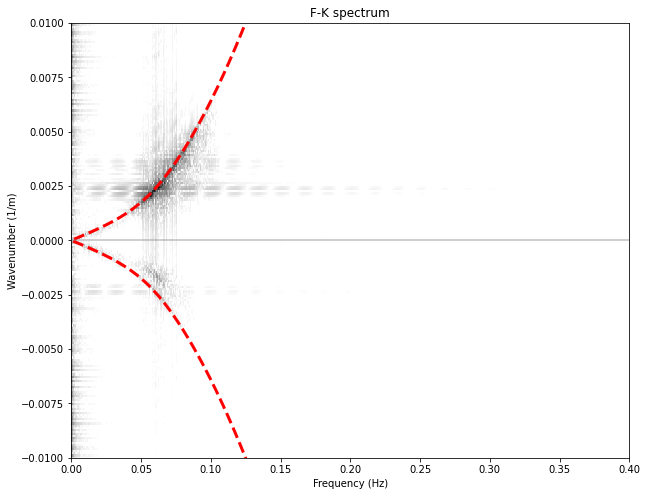

In [7]:
import matplotlib
matplotlib.rcParams.update({'font.size': 15})
fig1,ax = plt.subplots(1,1,figsize=(10,8))

# data_slice = full_dat[:,::10]
dx = 2.042
fs = 200.

fk = np.fft.fft2(full_dat)
fk = np.fft.fftshift(fk)
fk = 20*np.log10(abs(fk))

# Get FK axes
f = np.fft.fftshift(np.fft.fftfreq(full_dat.shape[1],d=1./fs))
k = np.fft.fftshift(np.fft.fftfreq(full_dat.shape[0],d=dx))

# Get theoretical dispersion relation
h = 141.77 # water depth (m)
f_OSGW = np.sqrt(9.8*2*np.pi*k * np.tanh(2*np.pi*k*h)) * (0.5/np.pi)

# Plot FK spectrum 
cp = ax.pcolormesh(f,k,fk,vmin=-10,vmax=45., cmap="Greys")
ax.plot(f_OSGW,k,'r--', linewidth=3)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Wavenumber (1/m)')
ax.set_title('F-K spectrum')
ax.set_xlim([0,0.40])
ax.set_ylim([-0.01,0.01])
ax.hlines(0., -1.,1.,colors="gray", alpha=0.5)
# plt.colorbar(cp, pad = 0.04,fraction=0.046)
plt.show()

In [6]:
# data_slice = full_dat[:,::10]
dx = 2.042
fs = 200.

fk = np.fft.fft2(full_dat)
fk = np.fft.fftshift(fk)
fk = 20*np.log10(abs(fk))

# Get FK axes
f = np.fft.fftshift(np.fft.fftfreq(full_dat.shape[1],d=1./fs))
k = np.fft.fftshift(np.fft.fftfreq(full_dat.shape[0],d=dx))

# Get theoretical dispersion relation
h = 141.77 # water depth (m)
f_OSGW = np.sqrt(9.8*2*np.pi*k * np.tanh(2*np.pi*k*h)) * (0.5/np.pi)

#get practical dispersion relation
pract = (25.441*k)-(5312.788*k**3)



In [21]:
pract = (25.441*k)-(30.788*k**3)


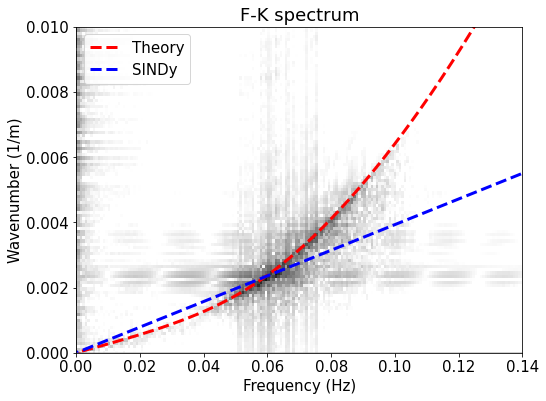

In [22]:
import matplotlib
matplotlib.rcParams.update({'font.size': 15})

# Plot FK spectrum 
fig1,ax = plt.subplots(1,1,figsize=(8,6))
cp = ax.pcolormesh(f[126000:127000],k,fk[:,126000:127000],vmin=-10,vmax=45., cmap="Greys")
ax.plot(f_OSGW,k,'r--', linewidth=3, label="Theory")
ax.plot(pract,k,'b--', linewidth=3,label="SINDy")

ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Wavenumber (1/m)')
ax.set_title('F-K spectrum')
ax.set_xlim([0,0.14])
ax.set_ylim([0.0,0.01])
ax.hlines(0., -1.,1.,colors="gray", alpha=0.5)
# plt.colorbar(cp, pad = 0.04,fraction=0.046)
plt.legend()
plt.show()

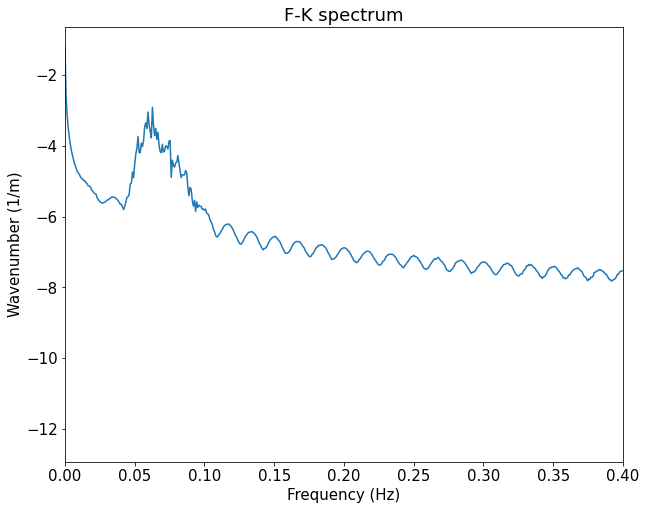

In [19]:
import matplotlib
matplotlib.rcParams.update({'font.size': 15})
fig1,ax = plt.subplots(1,1,figsize=(10,8))

# data_slice = full_dat[:,::10]
dx = 2.042
fs = 200.

fk = np.fft.fft(full_dat)
fk = np.fft.fftshift(fk)
fk = np.mean(np.abs(fk)**2,axis=0)
fk= np.log10(fk)
# # Get FK axes
# f = np.fft.fftshift(np.fft.fftfreq(full_dat.shape[1],d=1./fs))
# k = np.fft.fftshift(np.fft.fftfreq(full_dat.shape[0],d=dx))

# Get theoretical dispersion relation
# h = 141.77 # water depth (m)
# f_OSGW = np.sqrt(9.8*2*np.pi*k * np.tanh(2*np.pi*k*h)) * (0.5/np.pi)

# Plot FK spectrum 
cp = ax.plot(f,fk)
# ax.plot(f_OSGW,k,'r--', linewidth=3)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Wavenumber (1/m)')
ax.set_title('F-K spectrum')
ax.set_xlim([0,0.40])
# ax.set_ylim([0.,0.001])
# ax.hlines(0., -1.,1.,colors="gray", alpha=0.5)
# plt.colorbar(cp, pad = 0.04,fraction=0.046)
plt.show()

### Final Models

In [4]:
file_list = glob.glob("/home/ldoyle/notebooks/rad_10_smooth_data/*")

In [3]:
n = 1.4682
L = 51.04762

b=0
for q in np.arange(15,17):
    if b==0:
        working_dat = np.load(file_list[q])
        b=1
    else:
        working_dat = np.hstack((working_dat, np.load(file_list[q])))
        
working_dat = ((2*np.pi)/2**16)*((1550.12 * 1e-9)/(0.78 * 4 * np.pi * n * L))*working_dat#[:,::10]
working_dat = working_dat.T *10**6#/(np.std(working_dat))
working_dat = working_dat.reshape(working_dat.shape[0],working_dat.shape[1],1)

In [14]:
print(working_dat.shape)
print(np.amax(working_dat))
print(np.amin(working_dat))

(24000, 5000, 1)
2.108144129293724
-2.2477742469589814


In [15]:
dt=1./200
xs = 2.0419047*np.arange(working_dat.shape[1])
# time = dt*np.arange(working_dat.shape[0])

library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=4,
    spatial_grid=xs,
    include_bias=True,
    is_uniform=True,
#     periodic=True
)

In [16]:
thresh = 3.
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)


library_ensemble_coefs = model.coef_list
mean_library_ensemble = np.mean(library_ensemble_coefs, axis=0)
std_library_ensemble = np.std(library_ensemble_coefs, axis=0)

In [17]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()

Ensemble STLSQ with Threshold 3.0
(x0)' = -4.742 x0_1


In [18]:
thresh = 2.5
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)


library_ensemble_coefs = model.coef_list
mean_library_ensemble = np.mean(library_ensemble_coefs, axis=0)
std_library_ensemble = np.std(library_ensemble_coefs, axis=0)

In [19]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()

Ensemble STLSQ with Threshold 2.5
(x0)' = -4.538 x0_1 + -3.019 x0x0_1 + -5.336 x0x0_11


In [20]:
thresh = 2.
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)


library_ensemble_coefs = model.coef_list
mean_library_ensemble = np.mean(library_ensemble_coefs, axis=0)
std_library_ensemble = np.std(library_ensemble_coefs, axis=0)

In [21]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()

Ensemble STLSQ with Threshold 2.0
(x0)' = -4.652 x0_1 + -2.717 x0x0_1 + -5.248 x0x0_11


In [23]:
b=0
for q in np.arange(5,7):
    if b==0:
        working_dat = np.load(file_list[q])
        b=1
    else:
        working_dat = np.hstack((working_dat, np.load(file_list[q])))
        
working_dat = ((2*np.pi)/2**16)*((1550.12 * 1e-9)/(0.78 * 4 * np.pi * n * L))*working_dat 
working_dat = working_dat.T *10**6#/(np.std(working_dat))
working_dat = working_dat.reshape(working_dat.shape[0],working_dat.shape[1],1)

In [24]:
print(working_dat.shape)
print(np.amax(working_dat))
print(np.amin(working_dat))

(24000, 5000, 1)
2.0068433398443144
-2.104901850989071


In [25]:
dt=1./200
xs = 2.0419047*np.arange(working_dat.shape[1])
# time = dt*np.arange(working_dat.shape[0])

library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=4,
    spatial_grid=xs,
    include_bias=True,
    is_uniform=True,
#     periodic=True
)

In [26]:
thresh = 3.0
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)


library_ensemble_coefs = model.coef_list
mean_library_ensemble = np.mean(library_ensemble_coefs, axis=0)
std_library_ensemble = np.std(library_ensemble_coefs, axis=0)

In [27]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()

Ensemble STLSQ with Threshold 3.0
(x0)' = -4.259 x0_111


In [28]:
thresh = 2.5
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)


library_ensemble_coefs = model.coef_list
mean_library_ensemble = np.mean(library_ensemble_coefs, axis=0)
std_library_ensemble = np.std(library_ensemble_coefs, axis=0)

In [29]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()

Ensemble STLSQ with Threshold 2.5
(x0)' = -2.827 x0_1 + -9.465 x0_111 + 3.696 x0x0_111 + 8.054 x0x0_1111


In [30]:
thresh = 2.
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)


library_ensemble_coefs = model.coef_list
mean_library_ensemble = np.mean(library_ensemble_coefs, axis=0)
std_library_ensemble = np.std(library_ensemble_coefs, axis=0)

In [31]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()

Ensemble STLSQ with Threshold 2.0
(x0)' = -2.686 x0_1 + -9.316 x0_111 + 3.850 x0x0_111 + 8.516 x0x0_1111


In [4]:
b=0
for q in np.arange(23,25):
    if b==0:
        working_dat = np.load(file_list[q])
        b=1
    else:
        working_dat = np.hstack((working_dat, np.load(file_list[q])))
        
working_dat = ((2*np.pi)/2**16)*((1550.12 * 1e-9)/(0.78 * 4 * np.pi * n * L))*working_dat 
working_dat = working_dat.T *10**6#/(np.std(working_dat))
working_dat = working_dat.reshape(working_dat.shape[0],working_dat.shape[1],1)

In [5]:
print(working_dat.shape)
print(np.amax(working_dat))
print(np.amin(working_dat))

(24000, 5000, 1)
2.85174088422072
-3.0673507503575643


In [6]:
dt=1./200
xs = 2.0419047*np.arange(working_dat.shape[1])
# time = dt*np.arange(working_dat.shape[0])

library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=4,
    spatial_grid=xs,
    include_bias=True,
    is_uniform=True,
#     periodic=True
)

In [7]:
thresh = 3.0
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)


library_ensemble_coefs = model.coef_list
mean_library_ensemble = np.mean(library_ensemble_coefs, axis=0)
std_library_ensemble = np.std(library_ensemble_coefs, axis=0)

In [8]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()

Ensemble STLSQ with Threshold 3.0
(x0)' = -6.730 x0_1 + -4.194 x0_111


In [9]:
thresh = 2.5
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)


library_ensemble_coefs = model.coef_list
mean_library_ensemble = np.mean(library_ensemble_coefs, axis=0)
std_library_ensemble = np.std(library_ensemble_coefs, axis=0)

In [10]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()

Ensemble STLSQ with Threshold 2.5
(x0)' = -6.179 x0_1 + -3.748 x0_111


In [11]:
thresh = 2.
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)


library_ensemble_coefs = model.coef_list
mean_library_ensemble = np.mean(library_ensemble_coefs, axis=0)
std_library_ensemble = np.std(library_ensemble_coefs, axis=0)

In [12]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()

Ensemble STLSQ with Threshold 2.0
(x0)' = -6.566 x0_1 + -3.994 x0_111


In [54]:
b=0
for q in np.arange(19,21):
    if b==0:
        working_dat = np.load(file_list[q])
        b=1
    else:
        working_dat = np.hstack((working_dat, np.load(file_list[q])))
        
working_dat = ((2*np.pi)/2**16)*((1550.12 * 1e-9)/(0.78 * 4 * np.pi * n * L))*working_dat 
working_dat = working_dat.T *10**6#/(np.std(working_dat))
working_dat = working_dat.reshape(working_dat.shape[0],working_dat.shape[1],1)

In [55]:
print(working_dat.shape)
print(np.amax(working_dat))
print(np.amin(working_dat))

(24000, 5000, 1)
2.9800591644078525
-2.6265451104040913


In [56]:
dt=1./200
xs = 2.0419047*np.arange(working_dat.shape[1])
# time = dt*np.arange(working_dat.shape[0])

library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=4,
    spatial_grid=xs,
    include_bias=True,
    is_uniform=True,
#     periodic=True
)

In [57]:
thresh = 3.0
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)


library_ensemble_coefs = model.coef_list
mean_library_ensemble = np.mean(library_ensemble_coefs, axis=0)
std_library_ensemble = np.std(library_ensemble_coefs, axis=0)

In [58]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()

Ensemble STLSQ with Threshold 3.0
(x0)' = 8.839 x0_111


In [59]:
thresh = 2.5
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)


library_ensemble_coefs = model.coef_list
mean_library_ensemble = np.mean(library_ensemble_coefs, axis=0)
std_library_ensemble = np.std(library_ensemble_coefs, axis=0)

In [60]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()

Ensemble STLSQ with Threshold 2.5
(x0)' = 8.435 x0_111


In [61]:
thresh = 2.
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)


library_ensemble_coefs = model.coef_list
mean_library_ensemble = np.mean(library_ensemble_coefs, axis=0)
std_library_ensemble = np.std(library_ensemble_coefs, axis=0)

In [62]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()

Ensemble STLSQ with Threshold 2.0
(x0)' = -2.583 x0_1 + 5.150 x0_111


In [63]:
thresh = 1.
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)


library_ensemble_coefs = model.coef_list
mean_library_ensemble = np.mean(library_ensemble_coefs, axis=0)
std_library_ensemble = np.std(library_ensemble_coefs, axis=0)

In [64]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()

Ensemble STLSQ with Threshold 1.0
(x0)' = -1.867 x0_1 + 5.127 x0_111 + -2.225 x0x0_11 + -1.452 x0x0_111


In [73]:
xs = 2.0419047*10*np.arange(working_dat.shape[1])

library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=4,
    spatial_grid=xs,
    include_bias=True,
    is_uniform=True,
#     periodic=True
)

In [42]:
thresh = 3.
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt)#,ensemble=True)


# # library_ensemble_coefs = model.coef_list
# mean_library_ensemble = np.mean(library_ensemble_coefs, axis=0)
# std_library_ensemble = np.std(library_ensemble_coefs, axis=0)

SINDy(differentiation_method=FiniteDifference(axis=-2),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7f6900b5d370>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=50, threshold=3.0))

In [43]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()

Ensemble STLSQ with Threshold 3.0
(x0)' = 212.821 x0_111 + 7.296 x0x0_11 + -192.181 x0x0_1111 + -79.497 x0x0x0_1111


### Subsampled

In [5]:
n = 1.4682
L = 51.04762

b=0
for q in np.arange(5):
    if b==0:
        working_dat = np.load(file_list[q])
        b=1
    else:
        working_dat = np.hstack((working_dat, np.load(file_list[q])))
        
working_dat = ((2*np.pi)/2**16)*((1550.12 * 1e-9)/(0.78 * 4 * np.pi * n * L))*working_dat[:,::10]

working_dat = working_dat.T *10**6#/(np.std(working_dat))
mean_remove = (working_dat - np.mean(working_dat,axis=0)).T
working_dat = mean_remove.reshape(mean_remove.shape[0],mean_remove.shape[1],1)

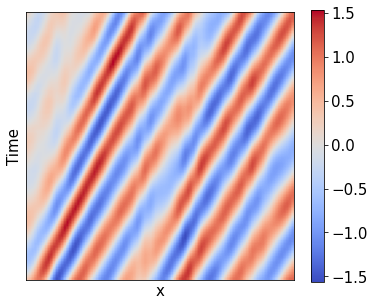

In [26]:
import matplotlib
matplotlib.rcParams.update({'font.size': 15})
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(6,5))
im =ax.imshow(mean_remove[:1000:10,:1000:10].T, cmap="coolwarm")
# ax.get_xticklabels().set_visible(False)
# ax.get_yticklabels().set_visible(False)
# plt.axis('off')
ax.set_xticks([])
ax.set_yticks([])
plt.ylabel("Time")
plt.xlabel("x")
fig.colorbar(im)
plt.show()

In [111]:
print(working_dat.shape)
print(np.amax(working_dat))
print(np.amin(working_dat))

(5000, 6000, 1)
1.962931407694355
-1.9319229386187655


In [112]:
dt=10./200
xs = 2.0419047*np.arange(working_dat.shape[0])
# time = dt*np.arange(working_dat.shape[0])

library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=4,
    spatial_grid=xs,
    include_bias=True,
    is_uniform=True,
#     periodic=True
)

In [113]:
xs.shape

(5000,)

In [114]:
thresh = 3.
optimizer = ps.STLSQ(threshold=thresh, alpha=0.01, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)


library_ensemble_coefs = model.coef_list
mean_library_ensemble = np.mean(library_ensemble_coefs, axis=0)
std_library_ensemble = np.std(library_ensemble_coefs, axis=0)

In [115]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()

Ensemble STLSQ with Threshold 3.0
(x0)' = 26.067 x0_1 + 5152.704 x0_111 + 72.901 x0x0_1111


In [116]:
thresh = 2.
optimizer = ps.STLSQ(threshold=thresh, alpha=1e-3, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

library_ensemble_coefs = model.coef_list
mean_library_ensemble = np.mean(library_ensemble_coefs, axis=0)
std_library_ensemble = np.std(library_ensemble_coefs, axis=0)

In [117]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()

Ensemble STLSQ with Threshold 2.0
(x0)' = 26.053 x0_1 + 5156.326 x0_111 + 34.255 x0x0_11 + 39.543 x0x0_1111


In [118]:
thresh = 20.
optimizer = ps.STLSQ(threshold=thresh, alpha=1e-3, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

library_ensemble_coefs = model.coef_list
mean_library_ensemble = np.mean(library_ensemble_coefs, axis=0)
std_library_ensemble = np.std(library_ensemble_coefs, axis=0)

In [119]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()

Ensemble STLSQ with Threshold 20.0
(x0)' = 26.059 x0_1 + 5157.999 x0_111 + 63.377 x0x0_1111


In [120]:
thresh = 20.
optimizer = ps.STLSQ(threshold=thresh, alpha=1e-5, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

library_ensemble_coefs = model.coef_list
mean_library_ensemble = np.mean(library_ensemble_coefs, axis=0)
std_library_ensemble = np.std(library_ensemble_coefs, axis=0)

In [121]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()

Ensemble STLSQ with Threshold 20.0
(x0)' = 26.061 x0_1 + 5159.268 x0_111 + 128.995 x0_1111 + 43.405 x0x0_11 + -450.118 x0x0x0_11 + 52.441 x0x0_1111 + -1189.162 x0x0x0_1111


In [136]:
n = 1.4682
L = 51.04762

b=0
for q in np.arange(15,20):
    if b==0:
        working_dat = np.load(file_list[q])
        b=1
    else:
        working_dat = np.hstack((working_dat, np.load(file_list[q])))
        
working_dat = ((2*np.pi)/2**16)*((1550.12 * 1e-9)/(0.78 * 4 * np.pi * n * L))*working_dat[:,::10]

working_dat = working_dat.T *10**6#/(np.std(working_dat))
mean_remove = (working_dat - np.mean(working_dat,axis=0)).T
working_dat = mean_remove.reshape(mean_remove.shape[0],mean_remove.shape[1],1)

In [137]:
print(working_dat.shape)
print(np.amax(working_dat))
print(np.amin(working_dat))

(5000, 6000, 1)
2.0020168824243667
-1.9447808378093412


In [138]:
dt=10./200
xs = 2.0419047*np.arange(working_dat.shape[0])
# time = dt*np.arange(working_dat.shape[0])

library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=4,
    spatial_grid=xs,
    include_bias=True,
    is_uniform=True,
#     periodic=True
)

In [127]:
thresh = 3.
optimizer = ps.STLSQ(threshold=thresh, alpha=0.01, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)


library_ensemble_coefs = model.coef_list
mean_library_ensemble = np.mean(library_ensemble_coefs, axis=0)
std_library_ensemble = np.std(library_ensemble_coefs, axis=0)

In [128]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()

Ensemble STLSQ with Threshold 3.0
(x0)' = 25.445 x0_1 + 5289.168 x0_111 + 126.153 x0x0_1111


In [129]:
thresh = 2.
optimizer = ps.STLSQ(threshold=thresh, alpha=1e-3, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

library_ensemble_coefs = model.coef_list
mean_library_ensemble = np.mean(library_ensemble_coefs, axis=0)
std_library_ensemble = np.std(library_ensemble_coefs, axis=0)

In [130]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()

Ensemble STLSQ with Threshold 2.0
(x0)' = 25.444 x0_1 + -2.514 x0_11 + 5290.436 x0_111 + -127.295 x0x0_11 + 139.553 x0x0_1111


In [139]:
thresh = 2.
optimizer = ps.STLSQ(threshold=thresh, alpha=0.01, max_iter=80)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

library_ensemble_coefs = model.coef_list
mean_library_ensemble = np.mean(library_ensemble_coefs, axis=0)
std_library_ensemble = np.std(library_ensemble_coefs, axis=0)

In [140]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()

Ensemble STLSQ with Threshold 2.0
(x0)' = 25.444 x0_1 + -2.885 x0_11 + 5288.368 x0_111 + 120.028 x0x0_1111


In [141]:
thresh = 20.
optimizer = ps.STLSQ(threshold=thresh, alpha=0.1, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

library_ensemble_coefs = model.coef_list
mean_library_ensemble = np.mean(library_ensemble_coefs, axis=0)
std_library_ensemble = np.std(library_ensemble_coefs, axis=0)
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()


Ensemble STLSQ with Threshold 20.0
(x0)' = 25.441 x0_1 + 5312.788 x0_111


### NO UNITS

In [8]:
n = 1.4682
L = 51.04762

b=0
for q in np.arange(5):
    if b==0:
        working_dat = np.load(file_list[q])
        b=1
    else:
        working_dat = np.hstack((working_dat, np.load(file_list[q])))
        
working_dat = ((2*np.pi)/2**16)*((1550.12 * 1e-9)/(0.78 * 4 * np.pi * n * L))*working_dat
working_dat = working_dat *10**6#/(np.std(working_dat))
working_dat = working_dat.reshape(working_dat.shape[0],working_dat.shape[1],1)

In [9]:
working_dat.shape

(5000, 60000, 1)

In [10]:
dt=1.
xs = np.arange(working_dat.shape[0])
# time = dt*np.arange(working_dat.shape[0])

library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=4,
    spatial_grid=xs,
    include_bias=True,
    is_uniform=True,
#     periodic=True
)

In [11]:
thresh = 5e-3
optimizer = ps.STLSQ(threshold=thresh, alpha=1e-4, max_iter=40)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

library_ensemble_coefs = model.coef_list
mean_library_ensemble = np.mean(library_ensemble_coefs, axis=0)
std_library_ensemble = np.std(library_ensemble_coefs, axis=0)

In [12]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()

Ensemble STLSQ with Threshold 0.005
(x0)' = 0.043 x0_1 + 1.895 x0_111 + 0.017 x0_1111 + -0.090 x0x0_11 + 0.152 x0x0x0_11 + 0.130 x0x0_1111
